✅ Librerías importadas correctamente

DATASET CARGADO
Filas:    52,535
Columnas: ['AnimalType', 'Color', 'Sex', 'IntakeType', 'IntakeCondition', 'TimeInShelterDays', 'AgeInDays', 'TimeInShelterDays_log', 'AgeGroup', 'breed_type', 'Breed_grouped', 'Color_grouped']

Nulos: 0

📊 Features: ['AnimalType', 'Sex', 'IntakeType', 'IntakeCondition', 'AgeInDays', 'AgeGroup', 'breed_type', 'Breed_grouped', 'Color_grouped']
📊 Target:   TimeInShelterDays_log

SPLIT 70 / 15 / 15
Train:      36,772 filas (70.0%)
Validation: 7,882  filas (15.0%)
Test:       7,881  filas (15.0%)
Total:      52,535 filas

✅ Preprocesador definido
   OHE:     ['AnimalType', 'Sex', 'IntakeType', 'IntakeCondition', 'breed_type', 'Breed_grouped', 'Color_grouped']
   Ordinal: ['AgeGroup']
   Scaler:  ['AgeInDays']


BLOQUE 1: MODELOS BASELINE

  LinearRegression
  Métrica                        Train        Val
  -----------------------------------------------
  MAE (log)                     0.9609     0.9544
  RMSE (log)    

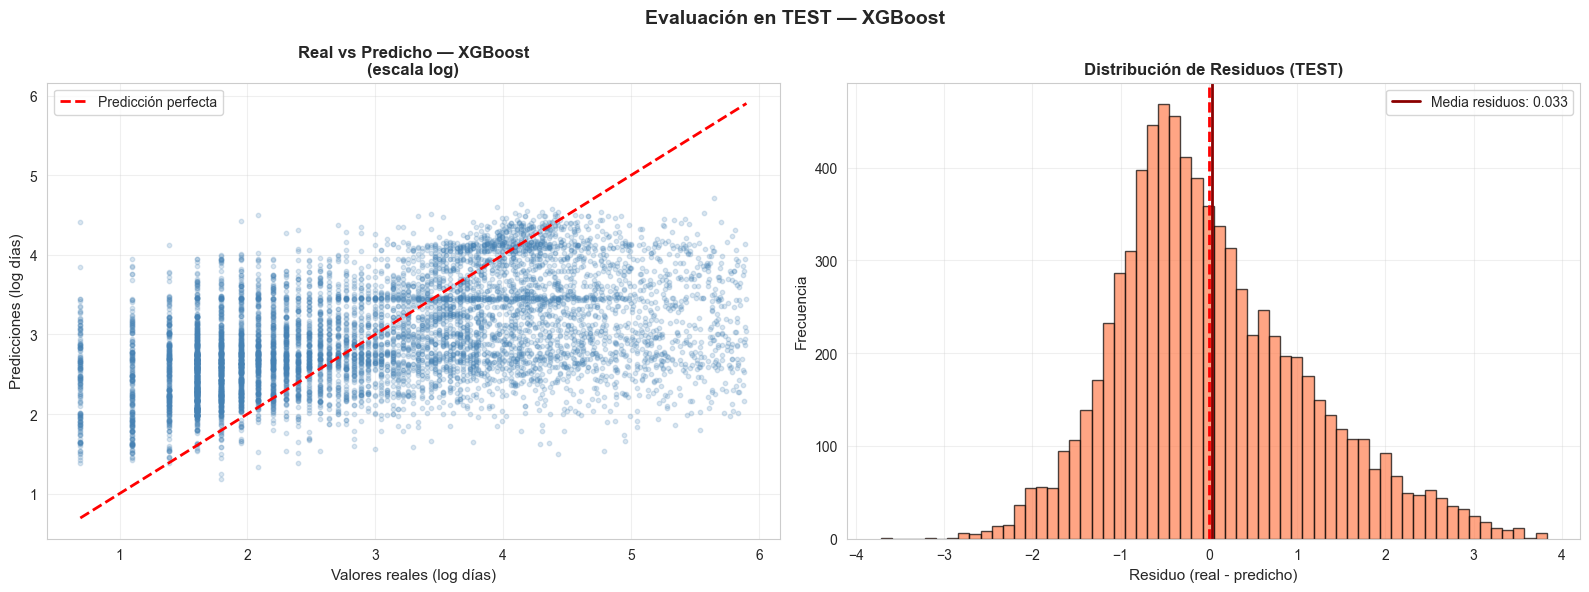


FEATURE IMPORTANCE — XGBoost


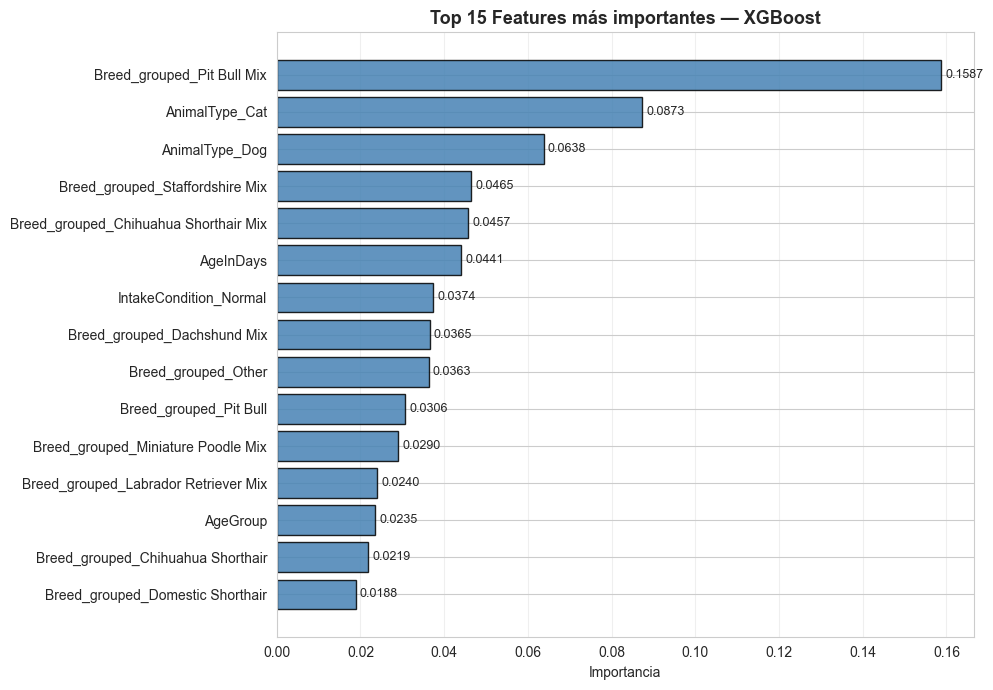


📊 Top 15 features:
                              feature  importance
           Breed_grouped_Pit Bull Mix    0.158672
                       AnimalType_Cat    0.087252
                       AnimalType_Dog    0.063753
      Breed_grouped_Staffordshire Mix    0.046481
Breed_grouped_Chihuahua Shorthair Mix    0.045686
                            AgeInDays    0.044116
               IntakeCondition_Normal    0.037393
          Breed_grouped_Dachshund Mix    0.036538
                  Breed_grouped_Other    0.036268
               Breed_grouped_Pit Bull    0.030648
   Breed_grouped_Miniature Poodle Mix    0.029030
 Breed_grouped_Labrador Retriever Mix    0.023952
                             AgeGroup    0.023485
    Breed_grouped_Chihuahua Shorthair    0.021862
     Breed_grouped_Domestic Shorthair    0.018847


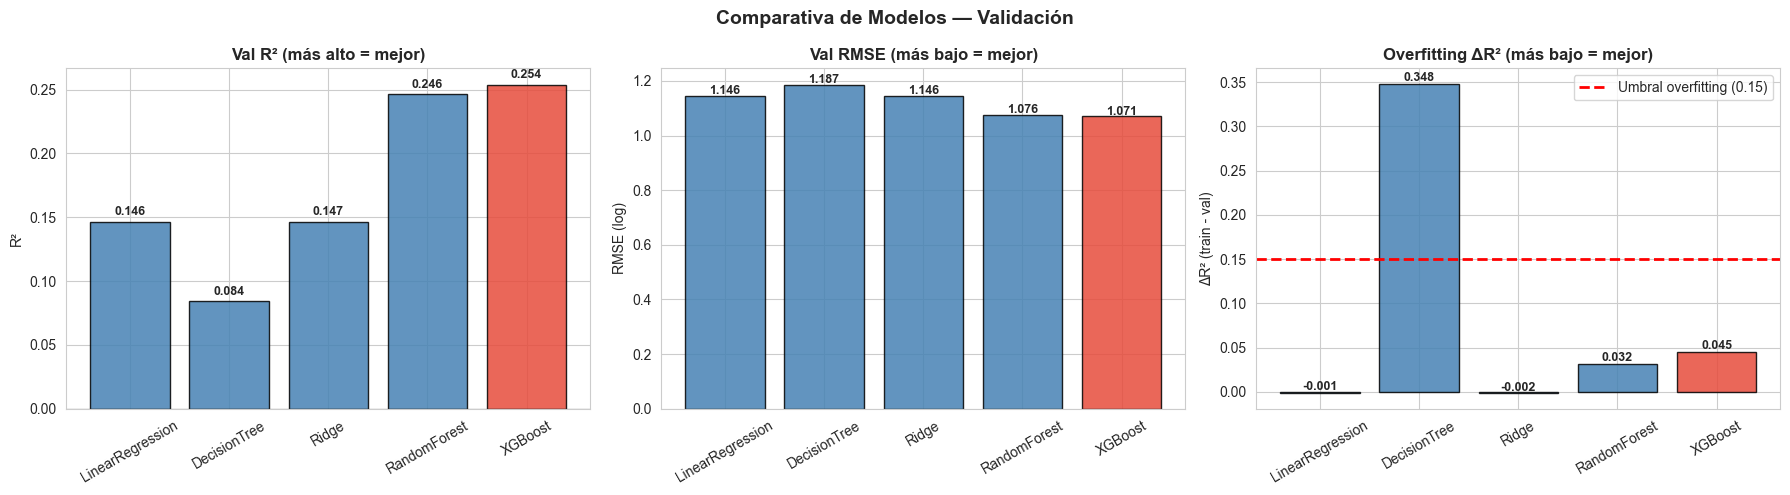


💾 Mejor modelo guardado: best_model_XGBoost.pkl

✅ MODELADO COMPLETADO

  Mejor modelo:       XGBoost
  Val R²:             0.2540
  Val RMSE (log):     1.0711
  Test R²:            0.2381
  Test MAE días:      30.5 días
  Test RMSE días:     61.3 días


In [1]:
# ==========================================================
# 03. MODELADO — Austin Animal Center: Pet Adoption
# ==========================================================
# Flujo completo:
#   1. Carga de datos
#   2. Split 70 / 15 / 15
#   3. Preprocesador (ColumnTransformer)
#   4. Baseline: LinearRegression + DecisionTree
#   5. Modelos avanzados: Ridge + RandomForest + XGBoost
#   6. Comparativa final
#   7. Evaluación en TEST del modelo ganador
#   8. Feature Importance
# ==========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100
os.makedirs('../models', exist_ok=True)

print("✅ Librerías importadas correctamente")


# ==========================================================
# 1. CARGA DE DATOS
# ==========================================================

df_model = pd.read_csv('../data/pet_adoption_model.csv')

print("\n" + "="*60)
print("DATASET CARGADO")
print("="*60)
print(f"Filas:    {len(df_model):,}")
print(f"Columnas: {list(df_model.columns)}")
print(f"\nNulos: {df_model.isnull().sum().sum()}")


# ==========================================================
# 2. FEATURES Y TARGET
# ==========================================================

FEATURES = [
    'AnimalType',
    'Sex',
    'IntakeType',
    'IntakeCondition',
    'AgeInDays',
    'AgeGroup',
    'breed_type',
    'Breed_grouped',
    'Color_grouped'
]

TARGET = 'TimeInShelterDays_log'

X = df_model[FEATURES].copy()
y = df_model[TARGET].copy()

print(f"\n📊 Features: {FEATURES}")
print(f"📊 Target:   {TARGET}")


# ==========================================================
# 3. TRAIN / VALIDATION / TEST SPLIT  (70 / 15 / 15)
# ==========================================================

# Paso 1: separar test (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# Paso 2: del 85% restante, sacar validation (~15% del total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42
)

print("\n" + "="*60)
print("SPLIT 70 / 15 / 15")
print("="*60)
print(f"Train:      {len(X_train):,} filas ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation: {len(X_val):,}  filas ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test:       {len(X_test):,}  filas ({len(X_test)/len(X)*100:.1f}%)")
print(f"Total:      {len(X_train)+len(X_val)+len(X_test):,} filas")


# ==========================================================
# 4. PREPROCESADOR (ColumnTransformer)
# ==========================================================

ohe_cols = [
    'AnimalType', 'Sex', 'IntakeType', 'IntakeCondition',
    'breed_type', 'Breed_grouped', 'Color_grouped'
]

ordinal_col    = ['AgeGroup']
numerical_cols = ['AgeInDays']

orden_edad = [[
    'Cachorro (<6m)',
    'Joven (6m-1a)',
    'Adulto joven (1-3a)',
    'Adulto (3-7a)',
    'Senior (>7a)'
]]

preprocessor = ColumnTransformer(transformers=[
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ohe_cols),
    ("ord", OrdinalEncoder(
        categories=orden_edad,
        handle_unknown="use_encoded_value",
        unknown_value=-1
    ), ordinal_col),
    ("num", StandardScaler(), numerical_cols)
], remainder='drop')

print("\n✅ Preprocesador definido")
print(f"   OHE:     {ohe_cols}")
print(f"   Ordinal: {ordinal_col}")
print(f"   Scaler:  {numerical_cols}")


# ==========================================================
# 5. FUNCIÓN DE EVALUACIÓN
# Métricas en escala log + conversión a días reales
# ==========================================================

all_results = {}

def evaluar_modelo(nombre, pipeline, X_tr, y_tr, X_v, y_v):
    pipeline.fit(X_tr, y_tr)

    y_tr_pred = pipeline.predict(X_tr)
    y_v_pred  = pipeline.predict(X_v)

    # Métricas en escala log
    r = {
        "pipeline":   pipeline,
        "train_mae":  mean_absolute_error(y_tr, y_tr_pred),
        "val_mae":    mean_absolute_error(y_v,  y_v_pred),
        "train_rmse": np.sqrt(mean_squared_error(y_tr, y_tr_pred)),
        "val_rmse":   np.sqrt(mean_squared_error(y_v,  y_v_pred)),
        "train_r2":   r2_score(y_tr, y_tr_pred),
        "val_r2":     r2_score(y_v,  y_v_pred),
    }
    r["overfit_r2"] = r["train_r2"] - r["val_r2"]

    # Métricas en días reales (deshacer log con expm1)
    dias_pred = np.expm1(y_v_pred)
    dias_true = np.expm1(y_v)
    r["val_mae_dias"]  = mean_absolute_error(dias_true, dias_pred)
    r["val_rmse_dias"] = np.sqrt(mean_squared_error(dias_true, dias_pred))

    print(f"\n{'='*55}")
    print(f"  {nombre}")
    print(f"{'='*55}")
    print(f"  {'Métrica':<25} {'Train':>10} {'Val':>10}")
    print(f"  {'-'*47}")
    print(f"  {'MAE (log)':<25} {r['train_mae']:>10.4f} {r['val_mae']:>10.4f}")
    print(f"  {'RMSE (log)':<25} {r['train_rmse']:>10.4f} {r['val_rmse']:>10.4f}")
    print(f"  {'R²':<25} {r['train_r2']:>10.4f} {r['val_r2']:>10.4f}")
    print(f"  {'Overfitting (ΔR²)':<25} {r['overfit_r2']:>10.4f}")
    print(f"  {'-'*47}")
    print(f"  {'MAE en días reales':<25} {r['val_mae_dias']:>10.1f} días")
    print(f"  {'RMSE en días reales':<25} {r['val_rmse_dias']:>10.1f} días")

    return r


# ==========================================================
# 6. BASELINE: LinearRegression + DecisionTree
# ==========================================================

print("\n\n" + "="*60)
print("BLOQUE 1: MODELOS BASELINE")
print("="*60)

baseline_models = {
    "LinearRegression": LinearRegression(),
    "DecisionTree":     DecisionTreeRegressor(random_state=42)
}

for nombre, modelo in baseline_models.items():
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", modelo)
    ])
    all_results[nombre] = evaluar_modelo(
        nombre, pipeline, X_train, y_train, X_val, y_val
    )


# ==========================================================
# 7. MODELOS AVANZADOS: Ridge + RandomForest + XGBoost
# ==========================================================

print("\n\n" + "="*60)
print("BLOQUE 2: MODELOS AVANZADOS")
print("="*60)

advanced_models = {
    "Ridge": Ridge(alpha=10.0),

    "RandomForest": RandomForestRegressor(
        n_estimators=200,
        max_depth=12,
        min_samples_leaf=10,
        random_state=42,
        n_jobs=-1
    ),

    "XGBoost": XGBRegressor(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )
}

for nombre, modelo in advanced_models.items():
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", modelo)
    ])
    all_results[nombre] = evaluar_modelo(
        nombre, pipeline, X_train, y_train, X_val, y_val
    )


# ==========================================================
# 8. COMPARATIVA FINAL DE TODOS LOS MODELOS
# ==========================================================

print("\n\n" + "="*75)
print("COMPARATIVA FINAL — TODOS LOS MODELOS (ordenado por Val RMSE)")
print("="*75)

print(f"\n  {'Modelo':<22} {'Val R²':>8} {'Val RMSE':>10} {'Val MAE':>9} "
      f"{'ΔR²':>8} {'MAE días':>10} {'RMSE días':>11}")
print(f"  {'-'*82}")

# Ordenar por val_rmse
sorted_results = sorted(all_results.items(), key=lambda x: x[1]['val_rmse'])

for nombre, r in sorted_results:
    mae_d  = f"{r['val_mae_dias']:.1f}"  if r.get('val_mae_dias')  else "—"
    rmse_d = f"{r['val_rmse_dias']:.1f}" if r.get('val_rmse_dias') else "—"
    print(f"  {nombre:<22} {r['val_r2']:>8.4f} {r['val_rmse']:>10.4f} "
          f"{r['val_mae']:>9.4f} {r['overfit_r2']:>8.4f} "
          f"{mae_d:>10} {rmse_d:>11}")


# ==========================================================
# 9. SELECCIÓN DEL MEJOR MODELO
# Criterio: menor RMSE en validación con overfitting < 0.15
# ==========================================================

mejor_nombre = None
mejor_val_rmse = np.inf

for nombre, r in all_results.items():
    if r['val_rmse'] < mejor_val_rmse and r['overfit_r2'] < 0.15:
        mejor_val_rmse = r['val_rmse']
        mejor_nombre   = nombre

mejor_pipeline = all_results[mejor_nombre]['pipeline']

print(f"\n🏆 MEJOR MODELO: {mejor_nombre}")
print(f"   Val RMSE (log): {all_results[mejor_nombre]['val_rmse']:.4f}")
print(f"   Val R²:         {all_results[mejor_nombre]['val_r2']:.4f}")
print(f"   MAE días reales:{all_results[mejor_nombre]['val_mae_dias']:.1f} días")


# ==========================================================
# 10. EVALUACIÓN FINAL EN TEST
# Solo se ejecuta una vez con el modelo ganador
# ==========================================================

print("\n\n" + "="*60)
print(f"EVALUACIÓN FINAL EN TEST — {mejor_nombre}")
print("="*60)
print("⚠️  Esta evaluación solo se hace UNA vez con el modelo ganador")

y_test_pred = mejor_pipeline.predict(X_test)

# Escala log
test_mae  = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2   = r2_score(y_test, y_test_pred)

# Días reales
dias_test_pred = np.expm1(y_test_pred)
dias_test_true = np.expm1(y_test)
test_mae_dias  = mean_absolute_error(dias_test_true, dias_test_pred)
test_rmse_dias = np.sqrt(mean_squared_error(dias_test_true, dias_test_pred))

print(f"\n  {'Métrica':<25} {'Valor':>12}")
print(f"  {'-'*38}")
print(f"  {'MAE (log)':<25} {test_mae:>12.4f}")
print(f"  {'RMSE (log)':<25} {test_rmse:>12.4f}")
print(f"  {'R²':<25} {test_r2:>12.4f}")
print(f"  {'-'*38}")
print(f"  {'MAE días reales':<25} {test_mae_dias:>12.1f} días")
print(f"  {'RMSE días reales':<25} {test_rmse_dias:>12.1f} días")


# ==========================================================
# 11. GRÁFICO: Predicciones vs Valores Reales (TEST)
# ==========================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter: predicho vs real (escala log)
axes[0].scatter(y_test, y_test_pred, alpha=0.2, s=10, color='steelblue')
lims = [min(y_test.min(), y_test_pred.min()),
        max(y_test.max(), y_test_pred.max())]
axes[0].plot(lims, lims, 'r--', linewidth=2, label='Predicción perfecta')
axes[0].set_xlabel('Valores reales (log días)', fontsize=11)
axes[0].set_ylabel('Predicciones (log días)', fontsize=11)
axes[0].set_title(f'Real vs Predicho — {mejor_nombre}\n(escala log)', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Histograma de residuos
residuos = y_test - y_test_pred
axes[1].hist(residuos, bins=60, color='coral', edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1].axvline(residuos.mean(), color='darkred', linestyle='-', linewidth=2,
                label=f'Media residuos: {residuos.mean():.3f}')
axes[1].set_xlabel('Residuo (real - predicho)', fontsize=11)
axes[1].set_ylabel('Frecuencia', fontsize=11)
axes[1].set_title('Distribución de Residuos (TEST)', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.suptitle(f'Evaluación en TEST — {mejor_nombre}',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


# ==========================================================
# 12. FEATURE IMPORTANCE (RandomForest o XGBoost)
# ==========================================================

if mejor_nombre in ["RandomForest", "XGBoost"]:
    print(f"\n{'='*60}")
    print(f"FEATURE IMPORTANCE — {mejor_nombre}")
    print("="*60)

    prep_fit   = mejor_pipeline.named_steps["preprocessor"]
    modelo_fit = mejor_pipeline.named_steps["model"]

    nombres_ohe = prep_fit.named_transformers_["ohe"].get_feature_names_out(ohe_cols)
    feature_names = list(nombres_ohe) + ordinal_col + numerical_cols

    importancias = modelo_fit.feature_importances_
    df_imp = (pd.DataFrame({"feature": feature_names, "importance": importancias})
              .sort_values("importance", ascending=False))

    # Top 15
    top15 = df_imp.head(15)

    fig, ax = plt.subplots(figsize=(10, 7))
    bars = ax.barh(top15["feature"][::-1], top15["importance"][::-1],
                   color="steelblue", edgecolor="black", alpha=0.85)
    for bar, val in zip(bars, top15["importance"][::-1]):
        ax.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
                f'{val:.4f}', va='center', fontsize=9)
    ax.set_title(f"Top 15 Features más importantes — {mejor_nombre}",
                 fontsize=13, fontweight='bold')
    ax.set_xlabel("Importancia")
    ax.grid(axis="x", alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\n📊 Top 15 features:")
    print(df_imp.head(15).to_string(index=False))


# ==========================================================
# 13. GRÁFICO COMPARATIVO DE TODOS LOS MODELOS
# ==========================================================

nombres_modelos = list(all_results.keys())
val_r2_vals  = [all_results[n]['val_r2']   for n in nombres_modelos]
val_rmse_vals = [all_results[n]['val_rmse'] for n in nombres_modelos]
overfit_vals = [all_results[n]['overfit_r2'] for n in nombres_modelos]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colores = ['#e74c3c' if n == mejor_nombre else 'steelblue' for n in nombres_modelos]

# R² en validación
axes[0].bar(nombres_modelos, val_r2_vals, color=colores, edgecolor='black', alpha=0.85)
axes[0].set_title('Val R² (más alto = mejor)', fontweight='bold')
axes[0].set_ylabel('R²')
axes[0].tick_params(axis='x', rotation=30)
axes[0].axhline(0, color='black', linewidth=0.8)
for i, v in enumerate(val_r2_vals):
    axes[0].text(i, v + 0.005, f'{v:.3f}', ha='center', fontsize=9, fontweight='bold')

# RMSE en validación
axes[1].bar(nombres_modelos, val_rmse_vals, color=colores, edgecolor='black', alpha=0.85)
axes[1].set_title('Val RMSE (más bajo = mejor)', fontweight='bold')
axes[1].set_ylabel('RMSE (log)')
axes[1].tick_params(axis='x', rotation=30)
for i, v in enumerate(val_rmse_vals):
    axes[1].text(i, v + 0.005, f'{v:.3f}', ha='center', fontsize=9, fontweight='bold')

# Overfitting
axes[2].bar(nombres_modelos, overfit_vals, color=colores, edgecolor='black', alpha=0.85)
axes[2].axhline(0.15, color='red', linestyle='--', linewidth=2, label='Umbral overfitting (0.15)')
axes[2].set_title('Overfitting ΔR² (más bajo = mejor)', fontweight='bold')
axes[2].set_ylabel('ΔR² (train - val)')
axes[2].tick_params(axis='x', rotation=30)
axes[2].legend()
for i, v in enumerate(overfit_vals):
    axes[2].text(i, v + 0.003, f'{v:.3f}', ha='center', fontsize=9, fontweight='bold')

plt.suptitle('Comparativa de Modelos — Validación',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


# ==========================================================
# 14. GUARDAR MEJOR MODELO
# ==========================================================

joblib.dump(mejor_pipeline, f'../models/best_model_{mejor_nombre}.pkl')
print(f"\n💾 Mejor modelo guardado: best_model_{mejor_nombre}.pkl")

print("\n" + "="*60)
print("✅ MODELADO COMPLETADO")
print("="*60)
print(f"\n  Mejor modelo:       {mejor_nombre}")
print(f"  Val R²:             {all_results[mejor_nombre]['val_r2']:.4f}")
print(f"  Val RMSE (log):     {all_results[mejor_nombre]['val_rmse']:.4f}")
print(f"  Test R²:            {test_r2:.4f}")
print(f"  Test MAE días:      {test_mae_dias:.1f} días")
print(f"  Test RMSE días:     {test_rmse_dias:.1f} días")